In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import sys
sys.path.append('/content/gdrive/MyDrive/Tetris/Torch')

import os
import pickle
import time
from datetime import datetime
from statistics import mean, median
import random
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image
from google.colab.patches import cv2_imshow
from tqdm.notebook import tqdm
from collections import deque

from tetrisActions import Tetris as TetrisA
from tetrisbActions import Tetris as TetrisB

from plotting import modified_plot,simple_plot


In [ ]:
env_name='SmallBoard'
algo='DQNPropsActions'
Rew_Fun='Reward_C'
big=False
see_piece=True

ROOT  :: 
 /content/gdrive/MyDrive/Tetris/Torch/Runs/DQNPropsActions/SmallBoard/Reward_C/Sun Aug 15 19 34 01 2021
Hyperparameters :: Starting model = 0,    epsilon = 0.9,     Learing Rate = 0.0001,     gamma = 0.5,     epsilon_greedy_frames = 50000,    epsilon_random_frames =1000,    epsilon_min = 0.1,    max_memory_length = 100000,    update_network = 1000,     batch_size =32,    Total Games =15000,    num_actions=24,    See Piece=True


  0%|          | 0/15000 [00:00<?, ?it/s]

Mean Score ::  -258.141 Best Score ::  0  -- Max Score ::  0
Mean Lines Cleared ::  0.079
...saving checkpoint...
...saving checkpoint...
Mean Score ::  -236.418 Best Score ::  0  -- Max Score ::  0
Mean Lines Cleared ::  0.07
...saving checkpoint...
...saving checkpoint...
Mean Score ::  -226.323 Best Score ::  0  -- Max Score ::  0
Mean Lines Cleared ::  0.108
...saving checkpoint...
...saving checkpoint...
Mean Score ::  -233.707 Best Score ::  0  -- Max Score ::  0
Mean Lines Cleared ::  0.135
...saving checkpoint...
...saving checkpoint...
Mean Score ::  -195.973 Best Score ::  0  -- Max Score ::  0
Mean Lines Cleared ::  0.1
...saving checkpoint...
...saving checkpoint...
Mean Score ::  -175.806 Best Score ::  0  -- Max Score ::  0
Mean Lines Cleared ::  0.044
...saving checkpoint...
...saving checkpoint...
Mean Score ::  -139.05 Best Score ::  0  -- Max Score ::  0
Mean Lines Cleared ::  0.039
...saving checkpoint...
...saving checkpoint...
Mean Score ::  -138.785 Best Score :: 

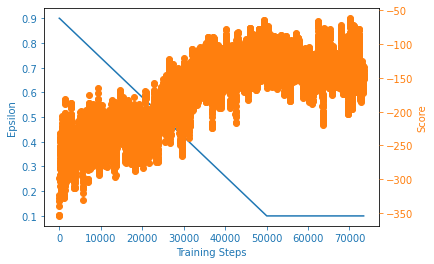

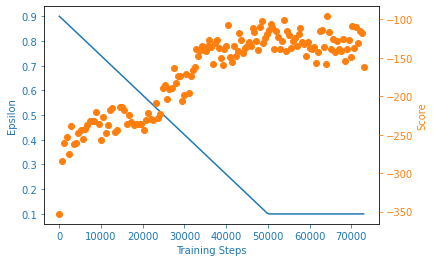

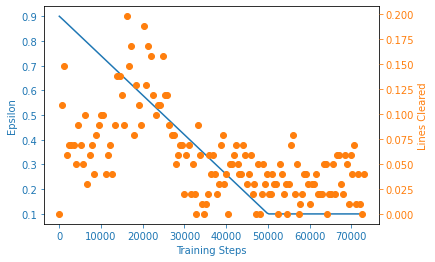

In [ ]:
load_checkpoint=False
baseRoot='/content/gdrive/MyDrive/Tetris/Torch/Runs'

if env_name=='FullBoard':
    env=TetrisA(Rew_Fun)
elif env_name=='SmallBoard':
    env=TetrisB(Rew_Fun)
else:
    print('NOT A CORRECT NAME SPECIFIED')
    exit()

if algo=='DQNPropsActions':
    from props_DQNActions import DQNAgent
elif algo=='DoubleDQNActions':
    from DoubleDQNActionsAgent import DoubleDQNAgent as DQNAgent
elif algo=='DuellingDQNActions':
    from DuellingDQNActionsAgent import DuellingDQNAgent as DQNAgent
elif algo=='DDuellingDQNActions':
    from DoubleDuellingDQNActionsAgent import DDuellingDQNAgent as DQNAgent
else:
    print('NOT A CORRECT NAME SPECIFIED')
    exit()

board_dim=np.expand_dims(np.array(env.board),axis=0).shape

all_actions=env.get_all_actions()
inshape=env.get_state_size()+1
n_actions=len(all_actions)
all_actions=[i for i in all_actions]
action_dictionary={i:all_actions[i] for i in range(len(all_actions))}

### 10k episodes -- 200k frames
### 100k episodes --- 2m frames
if not load_checkpoint:
    if big:
      start=0
      n_games=300_000
      epsilon=0.99
      gamma = 0.5
      lr=0.0001
      epsilon_greedy_frames = 3_000_000
      epsilon_random_frames =1000
      epsilon_min = 0.1
      max_memory_length = 300_000
      update_network =5000
      batch_size =32
      num_actions=n_actions

      stepping=1000
      parameters=[start,n_games,epsilon,gamma,lr,epsilon_greedy_frames,epsilon_random_frames,\
              epsilon_min,max_memory_length,update_network,batch_size,num_actions,stepping,see_piece]
      params=['start','n_games','epsilon','gamma','lr','epsilon_greedy_frames','epsilon_random_frames',\
        'epsilon_min','max_memory_length','update_network','batch_size','num_actions','stepping','See_piece']
    else:
      start=0
      n_games=15_000
      epsilon=0.9
      gamma = 0.5
      lr=0.0001
      epsilon_greedy_frames = 50_000
      epsilon_random_frames =1000
      epsilon_min = 0.1
      max_memory_length = 100_000
      update_network = 1000
      batch_size =32
      num_actions=n_actions
      stepping=100
      parameters=[start,n_games,epsilon,gamma,lr,epsilon_greedy_frames,epsilon_random_frames,\
        epsilon_min,max_memory_length,update_network,batch_size,num_actions,stepping,see_piece]
      params=['start','n_games','epsilon','gamma','lr','epsilon_greedy_frames','epsilon_random_frames',\
        'epsilon_min','max_memory_length','update_network','batch_size','num_actions','stepping','See_piece']

    baseRoot=os.path.join(baseRoot,algo)
    if os.path.isdir(baseRoot):
        baseRoot=os.path.join(baseRoot,env_name)
        if os.path.isdir(baseRoot):
            baseRoot=os.path.join(baseRoot,Rew_Fun)
            if os.path.isdir(baseRoot):
              pass
            else:
              os.mkdir(baseRoot)
        else:
            os.mkdir(baseRoot)
            baseRoot=os.path.join(baseRoot,Rew_Fun)
            os.mkdir(baseRoot)
    else:
        os.mkdir(baseRoot)
        baseRoot=os.path.join(baseRoot,env_name)
        os.mkdir(baseRoot)
        baseRoot=os.path.join(baseRoot,Rew_Fun)
        os.mkdir(baseRoot)

    #baseRoot= os.path.join(cwd,algo,env_name,"Runs")

    #baseRoot= "app/"+algo+"/"+env_name+"/Runs/"

    t = time.localtime()
    current_time = time.asctime(t)
    current_time=current_time.replace(':',' ')
    Root=os.path.join(baseRoot,str(current_time))

    os.mkdir(Root)
    print('ROOT  :: \n',Root)
    os.mkdir(Root+'/logs')
    os.mkdir(Root+'/models')
    os.mkdir(Root+'/buffer')
    os.mkdir(Root+'/statistics')
    log_summaries='/logs/summaries'
    log_trainings='/logs/training'
    with open(Root+log_trainings+'.txt','w') as c:
      c.write(f'Hyperparameters :: Starting model = {start},\
      epsilon = {epsilon}, \
      Learing Rate = {lr}, \
      gamma = {gamma}, \
      epsilon_greedy_frames = {epsilon_greedy_frames},\
      epsilon_random_frames ={epsilon_random_frames},\
      epsilon_min = {epsilon_min},\
      max_memory_length = {max_memory_length},\
      update_network = {update_network}, \
      batch_size ={batch_size},\
      Total Games ={n_games},\
      num_actions={num_actions},\
      See Piece={see_piece}')
      c.write('\n')
    pickle.dump( parameters, open( Root+'/hyperparameters.p', "wb" ))
    print(f'Hyperparameters :: Starting model = {start},\
    epsilon = {epsilon}, \
    Learing Rate = {lr}, \
    gamma = {gamma}, \
    epsilon_greedy_frames = {epsilon_greedy_frames},\
    epsilon_random_frames ={epsilon_random_frames},\
    epsilon_min = {epsilon_min},\
    max_memory_length = {max_memory_length},\
    update_network = {update_network}, \
    batch_size ={batch_size},\
    Total Games ={n_games},\
    num_actions={num_actions},\
    See Piece={see_piece}')
    best_score=0
    max_score=0
    scores, eps_history, steps_array,stats,lines_c = [], [], [],[],[]
    #wrong_action=[]
    latest_Root=Root

    agent=DQNAgent(dims=inshape,all_actions=all_actions,
             epsilon =epsilon, gamma = gamma,lr=lr,
             epsilon_greedy_frames = epsilon_greedy_frames,
             epsilon_random_frames =epsilon_random_frames,
             epsilon_min = epsilon_min,
             max_memory_length = max_memory_length,
             update_network = update_network,
             batch_size =batch_size,num_actions=num_actions,
             algo=algo,
             chkpt_dir=Root,
             env_name=env_name)
   
else:
  #Root=latest_Root
  Root='/content/gdrive/MyDrive/Tetris/Torch/Runs/DQNActions/FullBoard/Reward_C/Sat Aug 14 15 27 11 2021'
  log_summaries='/logs/summaries'
  log_trainings='/logs/training'
  parameters=pickle.load(open(Root+'/hyperparameters.p','rb'))
  start=pickle.load(open(Root+'/statistics/episode.p','rb'))
  
  n_games=parameters[1]
  #n_games=500_00
  epsilon=parameters[2]
  gamma=parameters[3]
  lr=parameters[4]
  epsilon_greedy_frames=parameters[5]
  epsilon_random_frames=parameters[6]
  epsilon_min=parameters[7]
  max_memory_length=parameters[8]
  update_network=parameters[9]
  batch_size=parameters[10]
  num_actions=parameters[11]
  stepping=parameters[12]
  see_piece=parameters[13]

  best_score=0
  max_score=0
  scores=pickle.load( open( Root+'/statistics/scores.p', "rb" ))
  stats=pickle.load( open( Root+'/statistics/summary.p', "rb" ))
  steps_array=pickle.load( open( Root+'/statistics/steps.p', "rb" ))
  eps_history=pickle.load( open( Root+'/statistics/eps_history.p', "rb" ))
  lines_c=pickle.load( open( Root+'/statistics/lines_cleared.p', "rb" ))
  #wrong_action=pickle.load( open( Root+'/statistics/wrong_actions.p', "rb" ))
  agent=DQNAgent(dims=inshape,all_actions=all_actions,
          epsilon =epsilon, gamma = gamma,lr=lr,
          epsilon_greedy_frames = epsilon_greedy_frames,
          epsilon_random_frames =epsilon_random_frames,
          epsilon_min = epsilon_min,
          max_memory_length = max_memory_length,
          update_network = update_network,
          batch_size =batch_size,num_actions=num_actions,
          algo=algo,
          chkpt_dir=Root,
          env_name=env_name)
  agent.frames=steps_array[-1]
  agent.epsilon=eps_history[-1]
  agent.load_models(start)
  agent.memory.load_buffer(Root)
  epsilon=eps_history[-1]
  print('LOADED CHECKPOINT')
  print('ROOT  :: \n',Root)
  print(f'Hyperparameters :: Starting model = {start},\
  epsilon = {epsilon}, \
  Learing Rate = {lr}, \
  gamma = {gamma}, \
  epsilon_greedy_frames = {epsilon_greedy_frames},\
  epsilon_random_frames ={epsilon_random_frames},\
  epsilon_min = {epsilon_min},\
  max_memory_length = {max_memory_length},\
  update_network = {update_network}, \
  batch_size ={batch_size},\
  Total Games ={n_games},\
  num_actions={num_actions},\
  See Piece={see_piece}')


for episode in tqdm(range(start+1,n_games+1)):
    current_state=env.reset()
    if see_piece:
      current_state.append(env.current_piece)
    else:
      pass
    done = False
    score=0
    tops=1000
    lines=0
    #wrong=0
    while not done :
        act=agent.choose_action(current_state)
        action=action_dictionary[act]
        reward, done,lc = env.play(action[0],action[1], render=False,
                                render_delay=0)
        board=env.board
        next_state=env._get_board_props(board)
        piece1=env.current_piece
        if see_piece:
          next_state.append(piece1)
        else:
          pass

        agent.store_transition(current_state,reward,next_state,done,act)
        agent.learn()
        current_state=next_state
        score+=reward
        #wrong+=c
        lines+=lc
        if (score >tops):
            tops+=1000
            with open(Root+log_trainings+'.txt','a') as c:
              c.write(f'Score : {score} ')
              c.write('\n')
    scores.append(score)
    lines_c.append(lines)
    #wrong_action.append(wrong)
    if score > max_score:
      max_score=score
    steps_array.append(agent.frames)
    eps_history.append(agent.epsilon)
    if episode % 10 == 0:
        avg_score = np.mean(scores[-10:])
        if avg_score>best_score:
            best_score=avg_score
        t = time.localtime()
        current_time = time.strftime("%H:%M:%S", t)
        with open(Root+log_trainings+'.txt','a') as c:
            c.write(f'episode: {episode} ,score: , {score}, lines cleared:{lines}\
average score {avg_score}, best score {best_score},\
epsilon {agent.epsilon},steps {agent.frames} ,time : {current_time}')
            c.write('\n')
    if (episode % 100)==0:
        summary={}
        summary['min'] = np.min(scores[-100:])
        summary['max'] = np.max(scores[-100:])
        summary['mean'] = np.mean(scores[-100:])
        stats.append(summary)
    if (episode % 1000)==0:
        print('Mean Score :: ',np.mean(scores[-1000:]),'Best Score :: ',best_score,' -- Max Score :: ',max_score)
        print('Mean Lines Cleared :: ',np.mean(lines_c[-1000:]))
        agent.save_models(episode)
    if (episode % 10000)==0:
        agent.memory.save_buffer(Root)
        pickle.dump( scores, open( Root+'/statistics/scores.p', "wb" ))
        pickle.dump( stats, open( Root+'/statistics/summary.p', "wb" ))
        pickle.dump( steps_array, open( Root+'/statistics/steps.p', "wb" ))
        pickle.dump( eps_history, open( Root+'/statistics/eps_history.p', "wb" ))
        pickle.dump( lines_c, open( Root+'/statistics/lines_cleared.p', "wb" ))
        pickle.dump(episode, open( Root+'/statistics/episode.p', "wb" ))


modified_plot(steps_array, scores, eps_history, Root+'/learning_score.png',stepping,'Score')
modified_plot(steps_array, lines_c, eps_history, Root+'/learning_lines.png',stepping,'Lines Cleared')